# Customer Satisfaction Analysis on E-commerce Data

## Project Objective
The objective of this project is to perform an in-depth analysis of customer satisfaction within the context of shipping times and product reviews in the e-commerce sector. The goal is to uncover the relationships between product characteristics (such as volume, weight, and density) and shipping times, assess the impact of shipping performance on customer satisfaction, and identify product categories that experience the most shipping issues. Using **Pandas** and **NumPy** for data manipulation, and **Matplotlib** and **Seaborn** for visualizations, this analysis aims to highlight key trends that can guide improvements in shipping efficiency and customer experience, ultimately informing strategies for enhancing review scores and reducing delays.

### Dataset Description
This dataset contains e-commerce order information from Olist, the largest department store on Brazilian marketplaces. It includes data on 100,000 orders made between 2016 and 2018 across various marketplaces in Brazil. The dataset's features allow for analyzing an order from multiple dimensions, including order status, price, payment and freight performance, customer location, geolocation information, product attributes, and customer reviews.

This is real commercial data released by Olist through Kaggle (a web-based platform for data science containing thousands of datasets for public use). The dataset has been anonymized for privacy purposes.

## Project Breakdown

### Section 1: Data Loading

In [4]:
# Import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset CSV files using pandas
customers = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_customers_dataset.csv')
order_items = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_order_items_dataset.csv')
payments = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_orders_dataset.csv')
products = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_products_dataset.csv')
sellers = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/olist_sellers_dataset.csv')
category_translation = pd.read_csv('/Users/jonathanjackson/Documents/olist_ecommerce_dataset/product_category_name_translation.csv')

# Merge the datasets together using the relationships defined in the schema below
df = pd.merge(orders, payments, how='left', on='order_id')
df = pd.merge(df, customers, how='left', on='customer_id')
df = pd.merge(df, order_items, how='right', on='order_id')
df = pd.merge(df, reviews, how='left', on='order_id')
df = pd.merge(df, products, how='left', on='product_id')
df = pd.merge(df, sellers, how='left', on='seller_id')
df = pd.merge(df, category_translation, how='right', on='product_category_name')

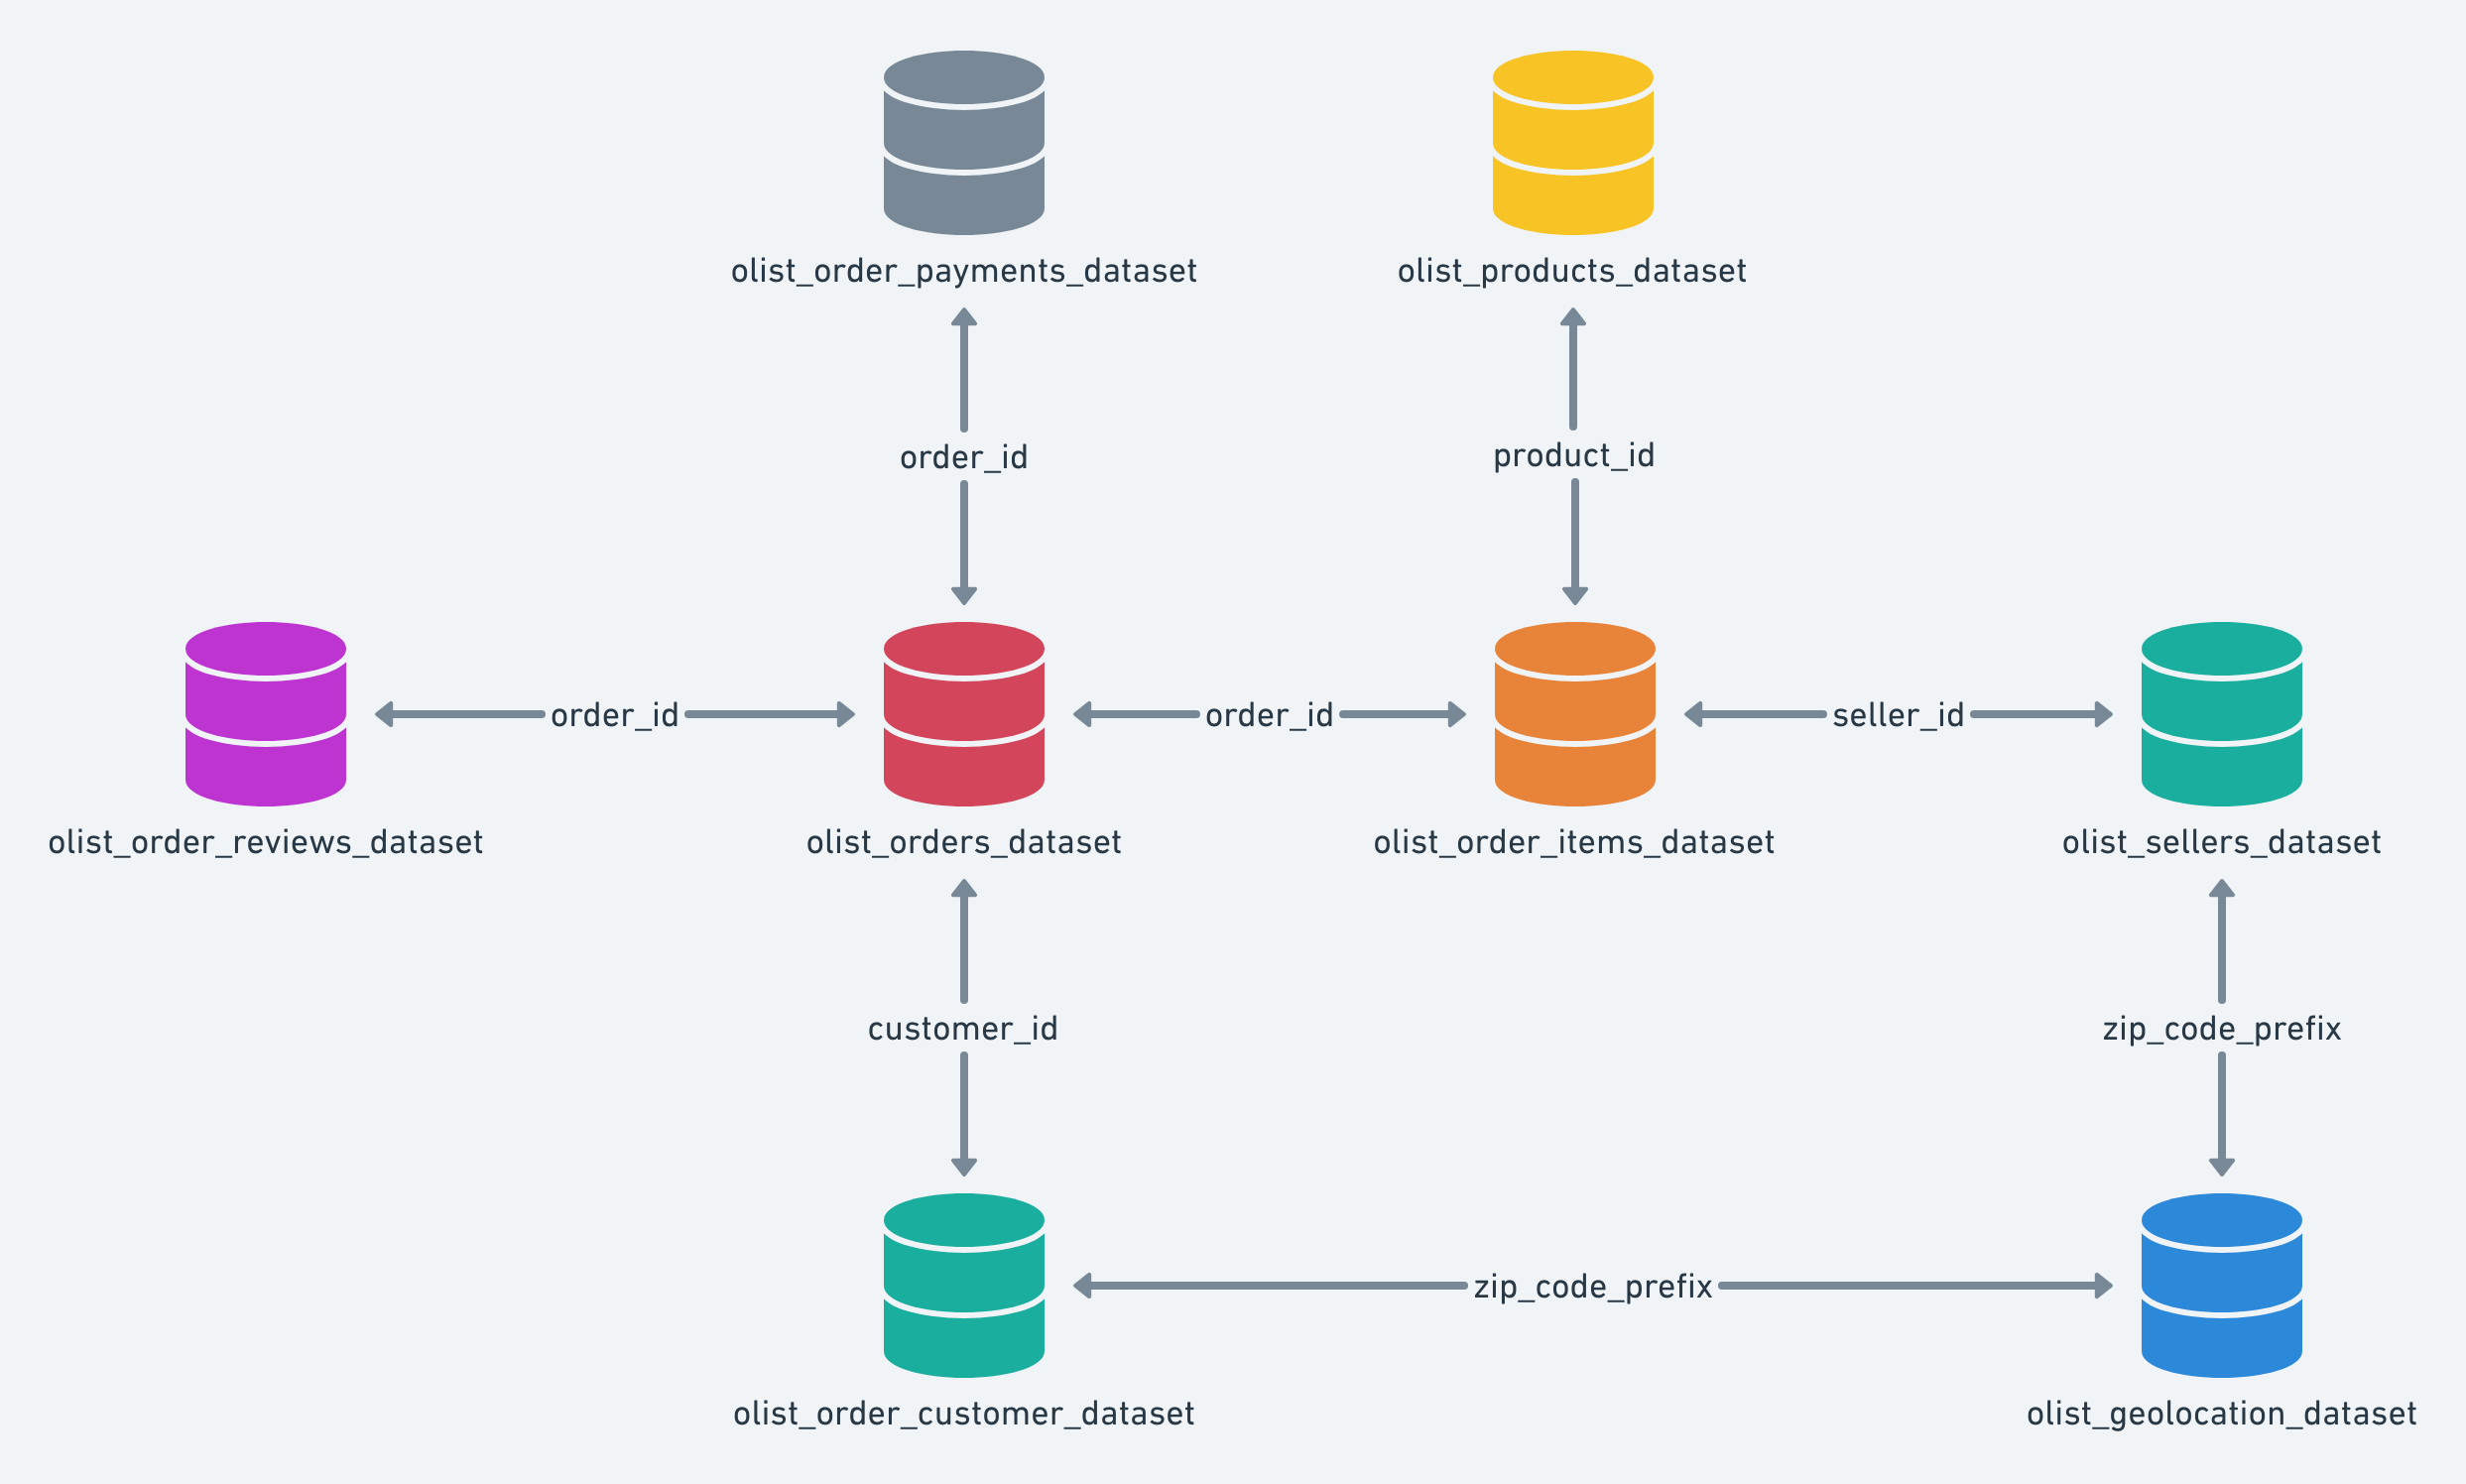

In [6]:
# Display a summary of information for all columns in the dataset  
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116576 entries, 0 to 116575
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116576 non-null  object 
 1   customer_id                    116576 non-null  object 
 2   order_status                   116576 non-null  object 
 3   order_purchase_timestamp       116576 non-null  object 
 4   order_approved_at              116562 non-null  object 
 5   order_delivered_carrier_date   115363 non-null  object 
 6   order_delivered_customer_date  114061 non-null  object 
 7   order_estimated_delivery_date  116576 non-null  object 
 8   payment_sequential             116573 non-null  float64
 9   payment_type                   116573 non-null  object 
 10  payment_installments           116573 non-null  float64
 11  payment_value                  116573 non-null  float64
 12  customer_unique_id            

- The summary of the dataset shows it contains **116,576 rows** and **40 columns** (some of which will be dropped as they are unnecessary for my analysis).
- Columns like *review_score* and *product_weight_g* contain null values that will need to be handled during preprocessing.
- There are also some columns, such as *product_weight_g*, that can be optimized to more suitable data types.

### Section 2: Data Pre-processing

- Here are the actions I'm going to take to pre-process this dataset:
    1. Drop irrelevant or redundant columns.
    2. Remove duplicate rows.
    3. Fill null values in numerical datatype columns with the median.
    4. Remove rows with null values that cannot be replaced, such as *order_delivered_customer_date*.
    5. Rename columns to more suitable naming conventions.
    6. Optimize column datatypes for analysis.
    7. Create custom columns.

In [9]:
# 1. Remove irrelevant columns
df = df.drop(columns=['order_approved_at',
                      'order_delivered_carrier_date',
                      'payment_sequential',
                      'payment_installments',
                      'customer_zip_code_prefix',
                      'shipping_limit_date',
                     'review_comment_title',
                     'review_comment_message',
                     'review_creation_date',
                     'review_answer_timestamp',
                     'product_category_name',
                     'product_name_lenght',
                     'product_description_lenght',
                     'product_photos_qty',
                     'seller_zip_code_prefix',
                    'customer_id',
                      'review_id'])

# Remove rows where the order status is not 'delivered,' as I want to focus on completed orders
df = df.drop(df[df['order_status'] != 'delivered'].index)

# Remove the order status column, as it is no longer relevant because all remaining orders are delivered
df = df.drop(columns='order_status')

# 2. Remove duplicate rows from the dataset
df = df.drop_duplicates()

# 3. Pass median into null values for numerical columns
df['payment_value'] = df.payment_value.fillna(df.payment_value.median())
df['review_score'] = df.review_score.fillna(df.review_score.median())
df['product_weight_g'] = df.product_weight_g.fillna(df.product_weight_g.median())
df['product_length_cm'] = df.product_length_cm.fillna(df.product_length_cm.median())
df['product_height_cm'] = df.product_height_cm.fillna(df.product_height_cm.median())
df['product_width_cm'] = df.product_width_cm.fillna(df.product_width_cm.median())

# 4. Removing remaining rows that contain null values
df = df.dropna()

# 5. Renaming some columns for increased interpretability
df = df.rename(columns={'order_item_id':'order_product_quantity',
                   'price':'item_price',
                    'order_delivered_customer_date':'order_delivered_timestamp',
                   'freight_value':'shipping_cost',
                   'payment_value':'total_cost',
                    'product_category_name_english':'product_category_name'})

# 6. Columns datatype optimization
# Change date and timestamp columns from object to datetime datatype
time_columns = ['order_purchase_timestamp',
                'order_delivered_timestamp',
                'order_estimated_delivery_date']

df[time_columns] = df[time_columns].apply(pd.to_datetime)

# Convert object columns to category type with the exception of columns that contain many unique values
categorical_columns = ['payment_type',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'product_category_name',
                       'review_score']

df[categorical_columns] = df[categorical_columns].astype('category')

# Show new dataframe summary info
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 113002 entries, 0 to 116575
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113002 non-null  object        
 1   order_purchase_timestamp       113002 non-null  datetime64[ns]
 2   order_delivered_timestamp      113002 non-null  datetime64[ns]
 3   order_estimated_delivery_date  113002 non-null  datetime64[ns]
 4   payment_type                   113002 non-null  category      
 5   total_cost                     113002 non-null  float64       
 6   customer_unique_id             113002 non-null  object        
 7   customer_city                  113002 non-null  category      
 8   customer_state                 113002 non-null  category      
 9   order_product_quantity         113002 non-null  int64         
 10  product_id                     113002 non-null  object        
 11  selle

In [10]:
# 7. Create custom columns for enhanced analysis of shipping and product attributes
df['order_shipping_days'] = (df['order_delivered_timestamp'] - df['order_purchase_timestamp']).dt.days
df['delivery_difference'] = (df['order_delivered_timestamp'] - df['order_estimated_delivery_date']).dt.days
df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df['product_density_si_unit'] = (df['product_weight_g'] / df['product_volume_cm3']) * 1000
df['shipping_timeliness'] = df['delivery_difference'].apply(lambda x: 'on_time' if x <= 0 else 'late')
df['order_item_count'] = df.groupby(['order_id'])['order_product_quantity'].transform('sum')

# Display all columns when showing the dataframe
pd.options.display.max_columns = None

# Display the first two rows of the dataframe to view custom columns
df.head(10)

,order_id,order_purchase_timestamp,order_delivered_timestamp,order_estimated_delivery_date,payment_type,total_cost,customer_unique_id,customer_city,customer_state,order_product_quantity,product_id,seller_id,item_price,shipping_cost,review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state,product_category_name,order_shipping_days,delivery_difference,product_volume_cm3,product_density_si_unit,shipping_timeliness,order_item_count
0,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,credit_card,157.60,639d23421f5517f69d0c3d6e6564cf0e,santos,SP,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,145.95,11.65,1.0,2000.0,30.0,12.0,16.0,sao paulo,SP,health_beauty,9,0,5760.0,347.222222,on_time,1
1,00061f2a7bc09da83e415a52dc8a4af1,2018-03-24 22:16:10,2018-03-29 00:04:19,2018-04-09,credit_card,68.87,107e6259485efac66428a56f10801f4f,piracicaba,SP,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,59.99,8.88,5.0,950.0,35.0,25.0,20.0,santo andre,SP,health_beauty,4,-11,17500.0,54.285714,on_time,1
2,001d8f0e34a38c37f7dba2a37d4eba8b,2017-05-14 17:19:44,2017-05-26 13:14:50,2017-05-24,credit_card,53.54,870a0bdc769f9a7870309036740e79ea,sao paulo,SP,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,1.0,150.0,43.0,13.0,14.0,sao paulo,SP,health_beauty,11,2,7826.0,19.166880,late,3
3,001d8f0e34a38c37f7dba2a37d4eba8b,2017-05-14 17:19:44,2017-05-26 13:14:50,2017-05-24,credit_card,53.54,870a0bdc769f9a7870309036740e79ea,sao paulo,SP,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,18.99,7.78,1.0,150.0,43.0,13.0,14.0,sao paulo,SP,health_beauty,11,2,7826.0,19.166880,late,3
4,001e7cf2ad6bef3ade12ebc56ceaf0f3,2018-05-19 10:29:23,2018-06-04 18:08:23,2018-06-05,credit_card,51.10,43860f86362fea12550bfa19ef73015f,coromandel,MG,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,35.90,15.20,1.0,1614.0,31.0,16.0,28.0,belo horizonte,MG,health_beauty,16,-1,13888.0,116.215438,on_time,1
5,0029c5db35ef291ce99d1262012e7daa,2018-08-25 00:09:40,2018-08-30 18:34:37,2018-09-03,boleto,514.37,b31e69e978d97f380d52102ac379fd7e,guarulhos,SP,1,7614c62b86a81021243e438cfde78ccc,900ba814c251a692506d7834c1218441,492.75,21.62,4.0,9900.0,30.0,39.0,38.0,salto,SP,health_beauty,5,-4,44460.0,222.672065,on_time,1
6,00345f338696283410b7977d2e3efc89,2018-08-20 11:06:46,2018-08-30 21:13:48,2018-09-11,credit_card,67.34,93b592cbb89abbda7dc554c39add344e,mogi-guacu,SP,1,0f2fd0a589cb7849c1dbedbd4109c2f8,516e7738bd8f735ac19a010ee5450d8d,48.90,18.44,5.0,870.0,19.0,17.0,15.0,rio de janeiro,RJ,health_beauty,10,-12,4845.0,179.566563,on_time,1
7,003d9fc84ad902adf2265248b5ffe1a4,2018-08-19 19:43:01,2018-08-27 18:17:49,2018-09-05,credit_card,94.74,f26b89209f5378f95d8e664073b76419,sao paulo,SP,1,3fbc0ef745950c7932d5f2a446189725,06a2c3af7b3aee5d69171b0e14f0ee87,66.99,27.75,4.0,350.0,19.0,12.0,13.0,sao luis,MA,health_beauty,7,-9,2964.0,118.083671,on_time,1
8,0045e3085f083f0f38d24bb3f22e6593,2017-08-10 16:13:36,2017-08-29 20:03:08,2017-08-30,credit_card,130.74,5eb8cc30e45a67bdb05240e7e735967d,sao jose dos campos,SP,1,9545d45c37449ccbc376de3a04c66e71,431af27f296bc6519d890aa5a05fdb11,116.90,13.84,5.0,1350.0,27.0,9.0,18.0,ribeirao preto,SP,health_beauty,19,-1,4374.0,308.641975,on_time,1
9,004b62108b876867938746ad3154167f,2018-07-04 20:34:26,2018-07-13 02:46:28,2018-07-19,boleto,118.35,49e67d53accc3f7540aa695b147e8b05,sao paulo,SP,1,c589625c8ccc7bfd2e8f1fb041e24c4a,c70c1b0d8ca86052f45a432a38b73958,110.32,8.03,5.0,150.0,22.0,3.0,15.0,hortolandia,SP,health_beauty,8,-6,990.0,151.515152,on_time,1


### Section 3: Exploratory Data Analysis & Data Visualization

The primary questions I'm looking to answer are:
1. **Do product attributes (weight, dimensions) influence shipping time?**
    - This insight can help ascertain whether heavier or bulkier items might have more complicated shipping and handling, potentially leading to increased shipping times.
2. **Does shipping time have an effect on product reviews?**
    - This insight can help assess whether longer shipping times are correlated with lower customer satisfaction.
3. **What product category has the most shipping issues?**
    - This insight could highlight impacts on product quality perceptions due to external factors like shipping and handling delays, even if the product itself meets customer expectations.

1. **The visualizations below showcase the correlation between product attributes and shipping time.**

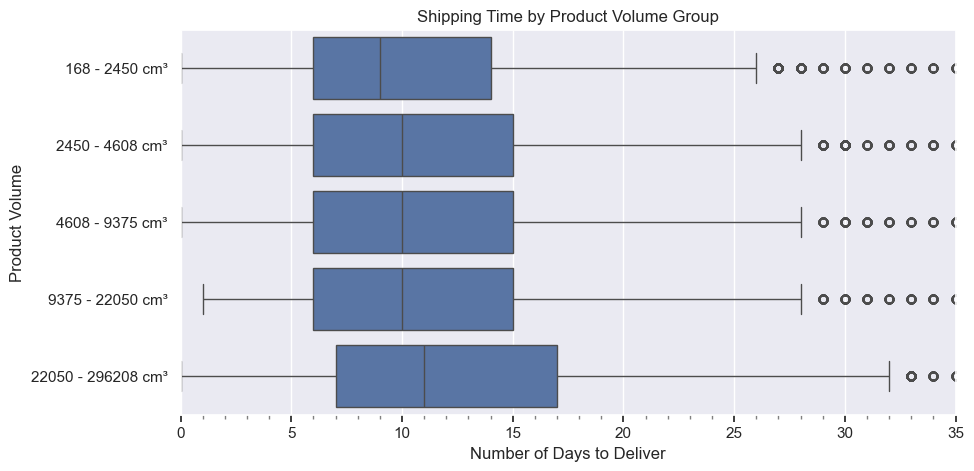

In [13]:
# What is the relationship between product volume and shipping time?
# Create 5 bins for product volume
df['volume_bins'], bin_edges = pd.qcut(df['product_volume_cm3'], q=5, labels=[f'D{d+1}' for d in range(5)], retbins=True)

# Boxplot: Product Volume vs. Shipping Time
sns.set_theme()
plt.figure(figsize = (10, 5))
sns.boxplot(data = df,
            x = 'order_shipping_days',
            y = 'volume_bins')

plt.title('Shipping Time by Product Volume Group')
plt.xlabel('Number of Days to Deliver')
plt.ylabel('Product Volume')
plt.xlim(0, 35)
plt.minorticks_on()

# Annotate the y-axis tick marks with the range of days for each bin and x-axis to show minor ticks
bin_labels = [f'{int(start)} - {int(end)} cm³' for start, end in zip(bin_edges[:-1], bin_edges[1:])]
ax = plt.gca()
ax.set_yticks(range(5))
ax.set_yticklabels(bin_labels)
ax.tick_params(axis='x', which='both', bottom=True, top=False, length=5)
ax.tick_params(axis='x', which='minor', length=3, color='gray')

plt.show()

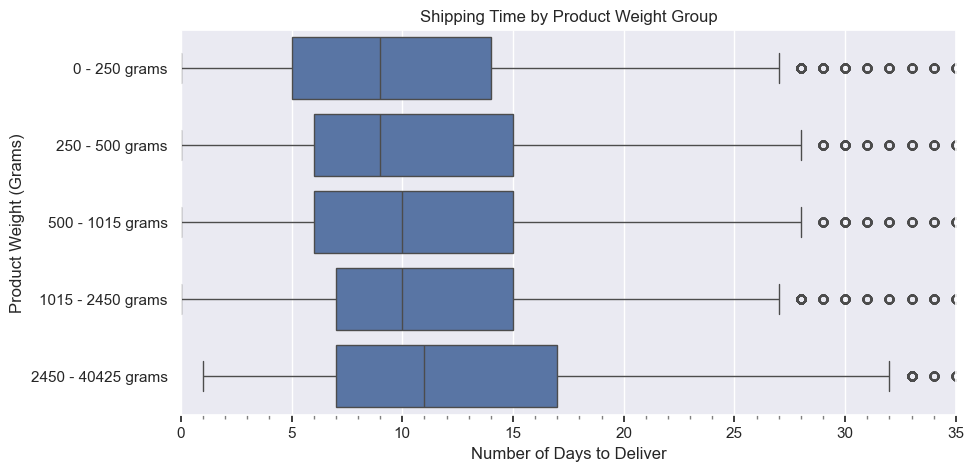

In [14]:
# Does product weight influence shipping time?
# Create 5 bins for product weight
df['weight_bins'], bin_edges = pd.qcut(df['product_weight_g'], q=5, labels=[f'D{d+1}' for d in range(5)], retbins=True)

# Boxplot: Product Weight vs. Shipping Time
plt.figure(figsize = (10, 5))
sns.boxplot(data = df,
            x = 'order_shipping_days',
            y = 'weight_bins')

plt.title('Shipping Time by Product Weight Group')
plt.xlabel('Number of Days to Deliver')
plt.ylabel('Product Weight (Grams)')
plt.xlim(0, 35)
plt.minorticks_on()

# Annotate the y-axis tick marks with the range of days for each bin & x-axis to show minor ticks
vol_labels = [f'{int(start)} - {int(end)} grams' for start, end in zip(bin_edges[:-1], bin_edges[1:])]
ax = plt.gca()
ax.set_yticks(range(5))
ax.set_yticklabels(vol_labels)
ax.tick_params(axis='x', which='both', bottom=True, top=False, length=5)
ax.tick_params(axis='x', which='minor', length=3, color='gray')

plt.show()

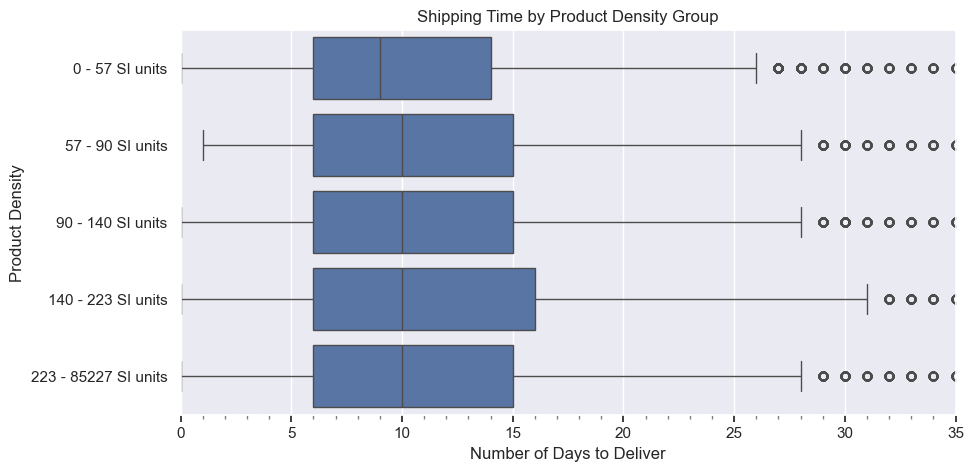

In [15]:
# Does product density influence shipping time?
# Create 5 bins for product density
df['density_bins'], bin_edges = pd.qcut(df['product_density_si_unit'], q=5, labels=[f'D{d+1}' for d in range(5)], retbins=True)

# Boxplot: Product Density vs. Shipping Time
plt.figure(figsize = (10, 5))
sns.boxplot(data = df,
            x = 'order_shipping_days',
            y = 'density_bins')

plt.title('Shipping Time by Product Density Group')
plt.xlabel('Number of Days to Deliver')
plt.ylabel('Product Density')
plt.xlim(0, 35)
plt.minorticks_on()

# Annotate the y-axis tick marks with the range of days for each bin & x-axis to show minor ticks
density_labels = [f'{int(start)} - {int(end)} SI units' for start, end in zip(bin_edges[:-1], bin_edges[1:])]
ax = plt.gca()
ax.set_yticks(range(5))
ax.set_yticklabels(density_labels)
ax.tick_params(axis='x', which='both', bottom=True, top=False, length=5)
ax.tick_params(axis='x', which='minor', length=3, color='gray')

plt.show()

2. **The visualization and descriptive statistics below showcase the correlation between shipping time and product reviews.**

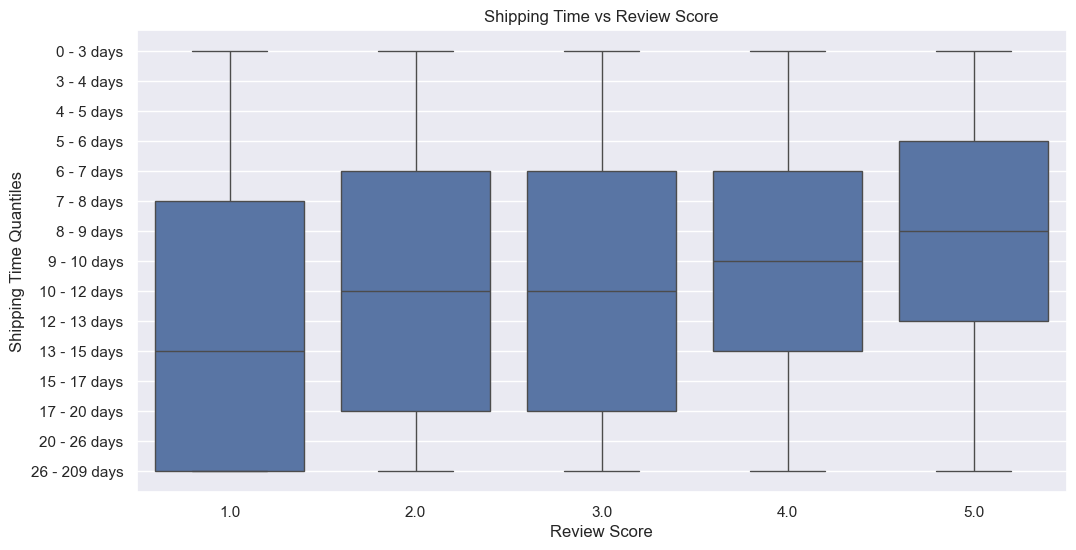

In [17]:
# Does shipping time influence product reviews?
# Create 15 bins for shipping time
df['shipping_time_bins'], bin_edges = pd.qcut(df['order_shipping_days'], q=15, labels=[f'D{d+1}' for d in range(15)], retbins=True)

# Boxplot: Shipping Time vs. Review Score
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,
            x='review_score',
            y='shipping_time_bins')

plt.title('Shipping Time vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Shipping Time Quantiles')

# Annotate the y-axis tick marks with the range of days for each bin
bin_labels = [f'{int(start)} - {int(end)} days' for start, end in zip(bin_edges[:-1], bin_edges[1:])]
ax = plt.gca()
ax.set_yticks(range(15))
ax.set_yticklabels(bin_labels)

plt.show()

In [18]:
# How many reviews with a score of 1 exceed or equal 13 days of shipping time?
# Filter the data for orders with shipping times greater than or equal to 13 days
long_shipping = df[df['order_shipping_days'] >= 13]

# Calculate the number of 1 score reviews
low_reviews = long_shipping[long_shipping['review_score'] == 1].shape[0]

# Calculate the total number of reviews with shipping times greater than 13 days
total_reviews_long_shipping = long_shipping.shape[0]

# Calculate the percentage of reviews with a score of 1 
low_review_percentage = (low_reviews / total_reviews_long_shipping) * 100

print(f"The percentage of reviews with a score of 1 for orders with shipping times equal to or exceeding 13 days is {low_review_percentage:.2f}%")

The percentage of reviews with a score of 1 for orders with shipping times equal to or exceeding 13 days is 17.86%


3. **Visualizations and descriptive statistics below showcasing the relationship between product categories and shipping timeliness.**

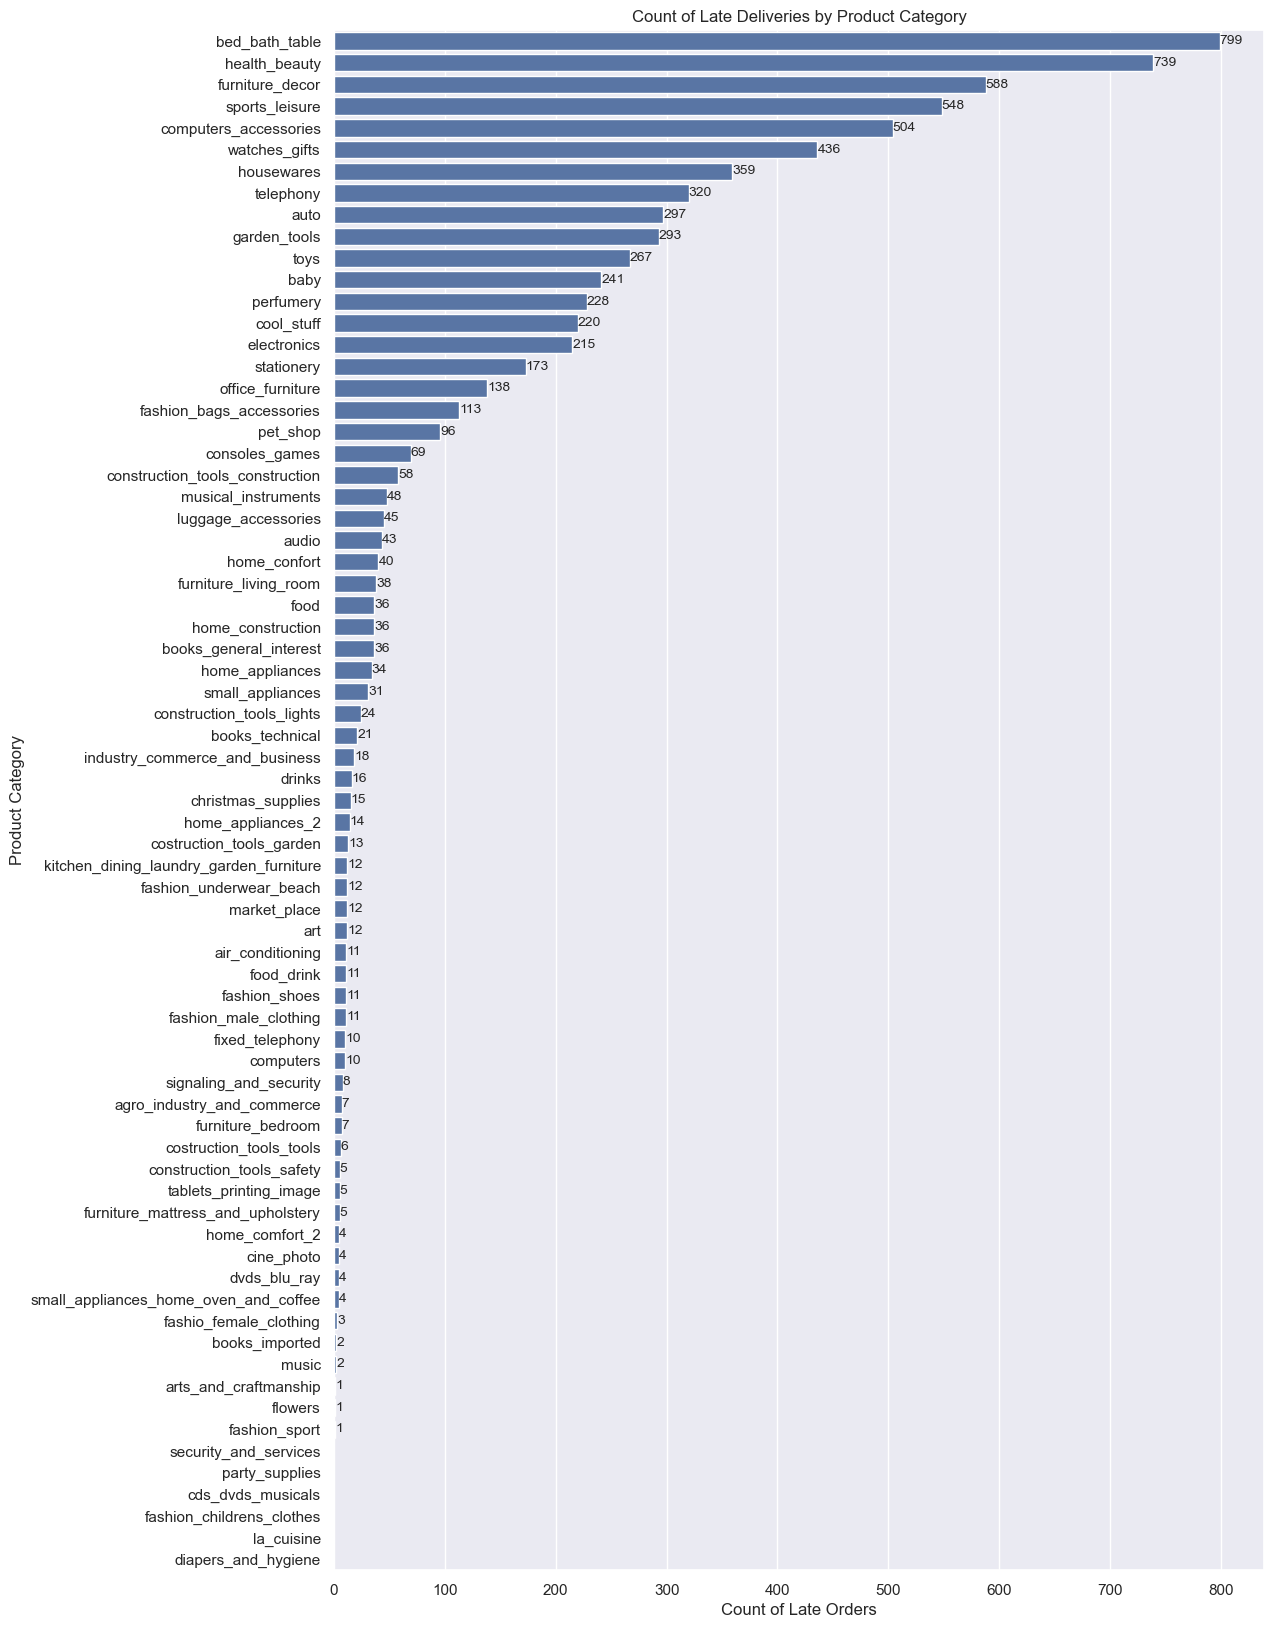

In [20]:
# How many late deliveries were made by each product category?
# Get the count of late deliveries by product category
late_delivery_counts = df[df['shipping_timeliness'] == 'late']['product_category_name'].value_counts()

# Bar chart: Late deliveries by product category
plt.figure(figsize=(12, 20))
ax = sns.countplot(
    data=df[df['shipping_timeliness'] == 'late'],
    y='product_category_name',
    order=late_delivery_counts.index)

plt.title('Count of Late Deliveries by Product Category')
plt.xlabel('Count of Late Orders')
plt.ylabel('Product Category')
ax.bar_label(ax.containers[0], fontsize=10);

plt.show()

In [21]:
# What percentage of deliveries from the Bed, Bath, & Table category were late?
# Filter the data for the "bed_bath_table" category
bed_bath_table_data = df[df['product_category_name'] == 'bed_bath_table']

# Count the number of late deliveries
late_deliveries = bed_bath_table_data[bed_bath_table_data['shipping_timeliness'] == 'late'].shape[0]

# Calculate the total number of deliveries in the category
total_deliveries = bed_bath_table_data.shape[0]

# Calculate the percentage of late deliveries
late_delivery_percentage = (late_deliveries / total_deliveries) * 100 if total_deliveries > 0 else 0

print(f"The percentage of late deliveries within the 'Bed, Bath, & Table' category is {late_delivery_percentage:.2f}%")

The percentage of late deliveries within the 'Bed, Bath, & Table' category is 6.87%


In [22]:
# What percentage of all late deliveries were experienced by the Bed, Bath & Table product category?
# Filter the data for late deliveries
late_deliveries = df[df['shipping_timeliness'] == 'late']

# Count the number of late deliveries in the "bed_bath_table" category
bed_bath_table_late = late_deliveries[late_deliveries['product_category_name'] == 'bed_bath_table'].shape[0]

# Calculate the total number of late deliveries
total_late_deliveries = late_deliveries.shape[0]

# Calculate the percentage of late deliveries in the "bed_bath_table" category
bed_bath_table_late_percentage = (bed_bath_table_late / total_late_deliveries) * 100 if total_late_deliveries > 0 else 0

print(f"The percentage of all late deliveries that were from the 'Bed, Bath, & Table' category is {bed_bath_table_late_percentage:.2f}%")

The percentage of all late deliveries that were from the 'Bed, Bath, & Table' category is 10.81%


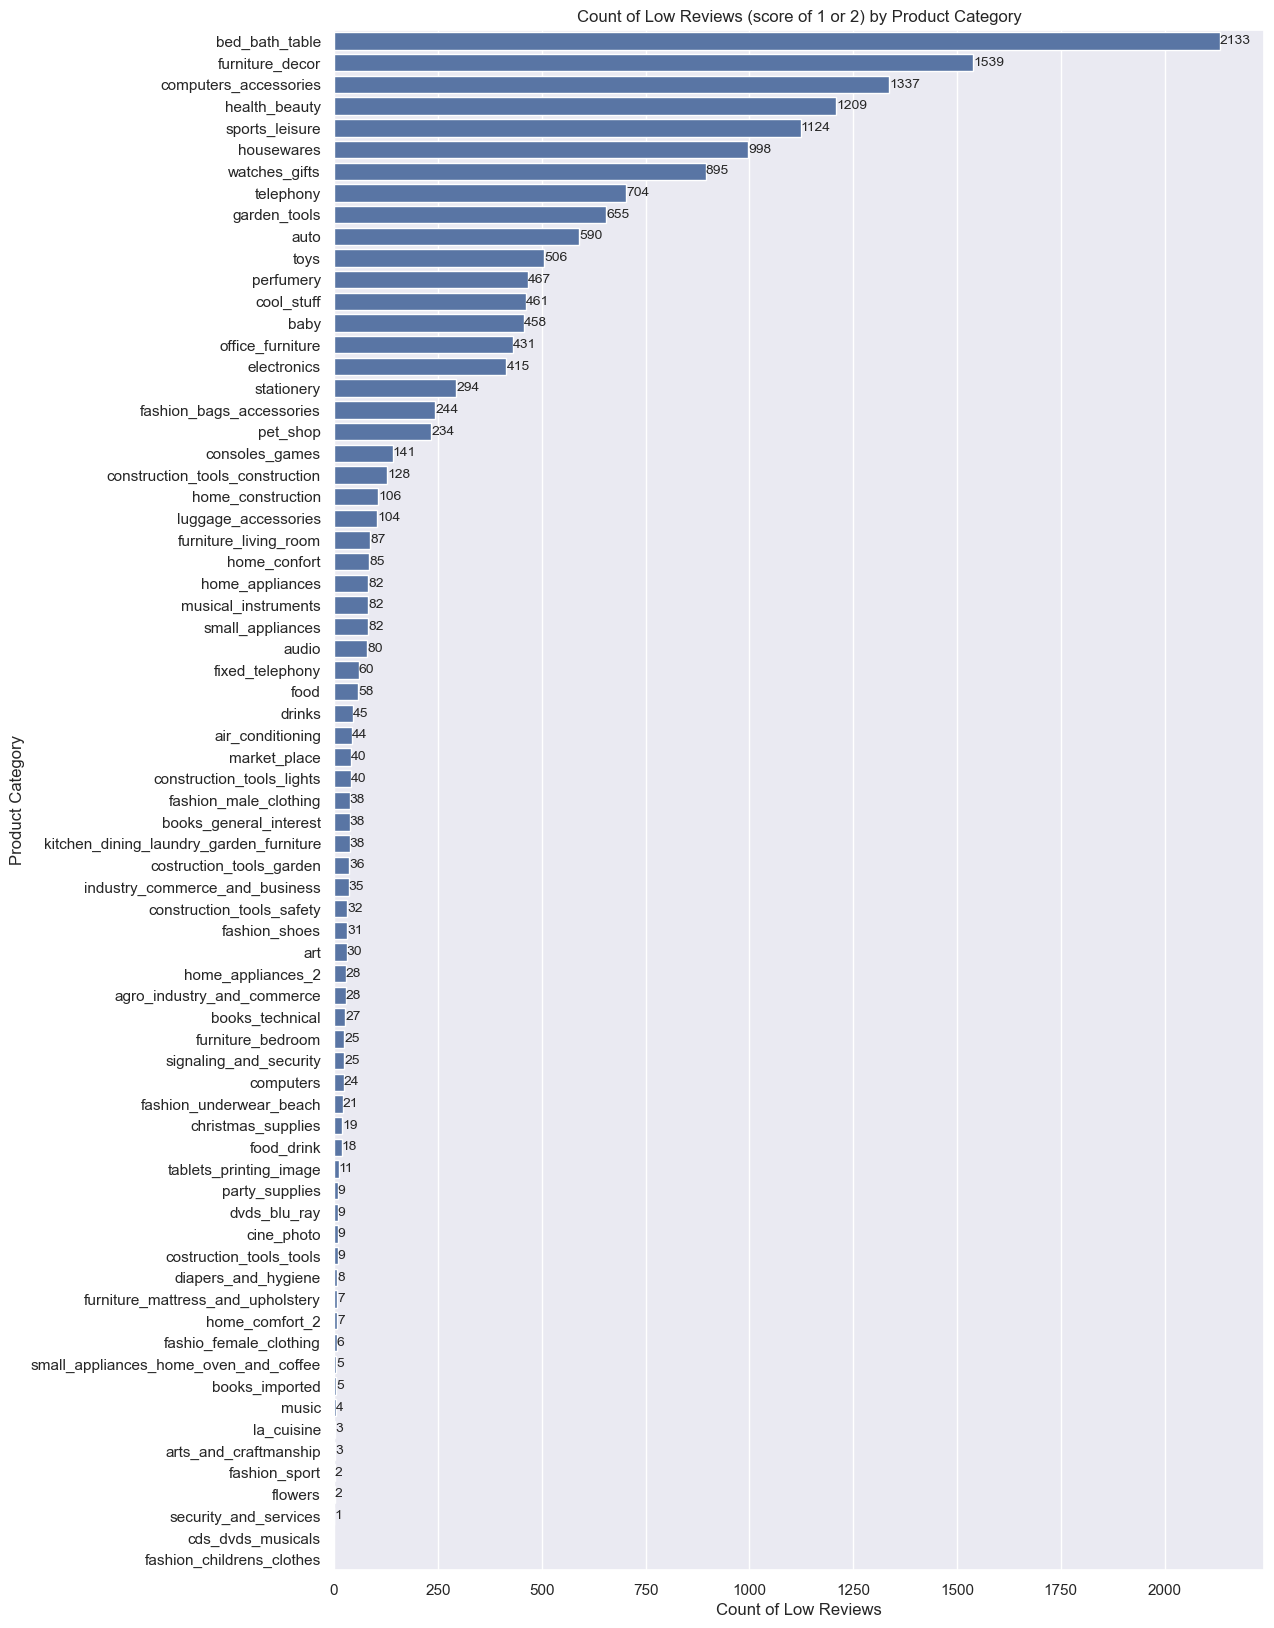

In [23]:
# What is the number of low reviews for each product category?
# Get the count of low review scores (1 and 2) by product category
low_score_counts = df[df['review_score'].isin([1, 2])]['product_category_name'].value_counts()

# Bar chart: Count of low reviews by product category
plt.figure(figsize=(12, 20))
ax = sns.countplot(
    data=df[df['review_score'].isin([1, 2])],
    y='product_category_name',
    order=low_score_counts.index)

plt.title('Count of Low Reviews (score of 1 or 2) by Product Category')
plt.xlabel('Count of Low Reviews')
plt.ylabel('Product Category')
ax.bar_label(ax.containers[0], fontsize=10);

plt.show()

# Section 4: Insights & Reporting

## 1. Introduction
This analysis aims to understand the relationship between product characteristics and shipping times, the impact of shipping performance on customer satisfaction, and which product categories experience the most shipping issues. The findings reveal important trends in shipping efficiency and areas for logistical improvement.

## 2. Key Findings

### 2.1 Do Product Attributes Influence Shipping Time?
- **Product Volume:**
  - Products were divided into quintiles based on their volume, ranging from the smallest (under 2,450 cm³) to the largest (over 22,050 cm³). The analysis showed that products in the largest volume bin took an average of 11 days to deliver, while those in the lowest volume quintile averaged only 9 days.
  - This indicates that bulkier items are likely to encounter more logistical challenges, contributing to longer delivery times.
- **Product Weight:**
  - The analysis of product weight revealed that heavier items (over 2,450 grams) experienced an average shipping time of 11 days, whereas lighter products (under 500 grams) averaged 9 days.
  - This trend suggests that heavier items may require additional handling or specialized shipping services, leading to delays.
- **Product Density:**
  - Items with higher density (over 57 SI units) showed a slight increase in shipping times (an average of 10 days), compared to items with lower density (under 57 SI units, averaging 9 days). The impact of density on shipping time was less pronounced than that of volume and weight.

### 2.2 Does Shipping Time Influence Product Reviews?
- **Correlation Between Shipping Time and Review Score:**
  - Orders with a review score of 5 were, on average, delivered within 8 or 9 days, while those with low review scores (3 or less) were, on average, delivered between 10 to 12 days. This negative correlation suggests that longer shipping times are associated with lower customer satisfaction.
  - When shipping times equal or exceed 13 days, nearly 18% of reviews were low (1 star), highlighting the importance of timely deliveries in maintaining high review scores.

### 2.3 What Product Categories Have the Most Shipping Issues?
- **Late Deliveries by Product Category:**
  - The *Bed, Bath, & Table* product category accounted for the highest number of late deliveries, with approximately 800 late deliveries. This category experienced delays in about 7% of their orders, accounting for approximately 11% of all late deliveries. This pattern suggests that the larger or more complex items in this category tend to face more logistical challenges.
- **Low Review Scores by Product Category:**
  - The category with the most low review scores (1 or 2) was the *Bed, Bath, & Table* product group, indicating potential quality issues or dissatisfaction due to their history of shipping delays.

## 3. Recommendations
- **Focus on Improving Logistics for Bulky and Heavy Items:**
  - Given the longer shipping times for large and heavy products, consider partnering with logistics providers who specialize in handling these items. Reducing delays could help improve customer satisfaction in these categories.
- **Improve Shipping Time for High-Impact Categories:**
  - Prioritize faster shipping for large furniture to minimize delays and enhance the customer experience.
- **Use Incentives to Boost Positive Reviews:**
  - Encourage customers to leave reviews for items delivered on time. This could help counteract the impact of negative reviews associated with delayed orders.

## 4. Conclusion
This analysis highlights the significant role that shipping time plays in customer satisfaction. Items that are larger, heavier, or belong to certain categories (such as Bed, Bath & Table) are more prone to shipping issues. Addressing these areas can enhance customer experiences, boost review scores, and drive repeat business.